# 资金流入流出预测-task1.探索性分析

**数据及背景**: 数据来自阿里天池https://tianchi.aliyun.com/competition/entrance/231573/introduction?spm=5176.12281973.1005.1.3dd52448IkdfCH。

**参考代码**：https://github.com/datawhalechina/team-learning-data-mining/blob/master/PurchaseAndRedemptionForecast

**学习目的**：通过数据挖掘项目了解时间分析模型和机器学习模型在处理金融时间序列数据时各自的优缺点。

**分析结论**

1.从数据分布来看周日到周三的购买量和赎回量集中在2到4之间，周四到周六集中在1-3之间，并且前者的中位数也明显高于后者(赎回量周四同周日到周三)；说明用户更喜欢在周初交易。另外购买量均匀分布在1.5到3.5之间,赎回量则更集中在2到3之间(单位100000000分)。

2.随着时间变化购买量和赎回量的箱线图上移，即都变大。从购买量来看14年2月份整体最高，然后降低到一个比较稳定的水平；赎回量14年3月份略微上涨然后保持和购买持平；购买量和赎回量相比在14年3月份以前都是购买量更大,3月份到5月份差异不大，6月和7月赎回量反超，8月份又基本持平。

3.每天特征分析整体看的不是很懂，最后的假设检验的相关理论不是特别清楚？

4.清明、劳动、端午三个节日的交易量明显低于平时的均值，618活动是交易量要高于平时的均值.取与节假日相同的时间段相比(三天)交易量也明显低于平时。

5.临近节假日交易量会下架后上涨，节假日交易量最低。

6.2013年11月4号出现单个用户购买2e8的最高交易记录,该用户当天赎回约1/2的金额，在1个月后又赎回了接近1/2的金额。之后又进行了多次小额购买，2014年6月赎回了1e8的金额。2e8的交易额(分析下当天占比)11月4号的总交易额要高于周边几天的总交易额；随着总交易额的上升，单个大交易额对总交易额的影响变小。2014年1-3月超过1e8的交易次数最多。大额交易（大于100万）购买大于赎回，14年5月出现了赎回大于购买的情况；小额交易购买一直大于赎回。两种交易在周五和周六时都比较低。

7.从相关性热力图可以看出和总购买量呈正相关的是今日直接购买量，今日银行卡购买量以及今日支付宝购买量；定性来看总购买量和另外三者存在等式关系。

8.总购买量和赎回量3个月到1年的拆解利率呈正相关，相关系数在0.5至0.75左右，相关度较高；而银行的短期拆解利率和总购买两和赎回量相关性几乎为0（隔夜拆解利率和总购买量和赎回量呈现弱负相关）。小额总购买量和赎回量和短期拆解利率负相关性更明显（高于-0.25）。大额赎回量和短期拆解利率呈现弱负相关性，购买量则不明显。短期(3个月以下)银行利率波动较大，长期银行利率在14年年初经历上涨之后比较稳定；其中3个月的拆解利率先上涨后下降。总购买量的变化趋势 和3个月的拆解利率比较一致先上涨后下降；赎回量和长期拆解利率的趋势比较一致上涨之后比较稳定。

9.总购买量和万份收益以及7日年化率呈比较高的相关性；赎回量和两者香瓜逆行较弱。从时序图象来看总购买量和万份收益的变化趋势也比较一致；赎回量趋势不一致。大额购买量和万份收益呈较高的相关性；小额的交易量以及大额的赎回量和万份收益的相关性较弱。银行拆解利率和支付宝万份收益变化的大致趋势一致，但是支付宝波动幅度更大。

In [3]:
import os
#数据分析包
import datetime
import numpy as np
import pandas as  pd
from scipy import stats
#可视化包
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [4]:
os.chdir('d:\\pythonsjkx\\Purchase Redemption Data')#设定工作路径
data_balance = pd.read_csv('user_balance_table.csv')

In [5]:
#Image(filename = 'mfd_day_share_interest', width=100, height=60) 插入图片

In [6]:
# 为数据集添加时间戳
data_balance['date'] = pd.to_datetime(data_balance['report_date'], format= "%Y%m%d")
data_balance['day'] = data_balance['date'].dt.day
data_balance['month'] = data_balance['date'].dt.month
data_balance['year'] = data_balance['date'].dt.year
data_balance['week'] = data_balance['date'].dt.week
data_balance['weekday'] = data_balance['date'].dt.weekday

## 一、时间序列分析
数据框形状2840421*24以及数据类型datetime64[ns](1), float64(4), int64(19)；其中4列存在缺失值2666682。

申购量和赎回量在2013年11月比较平稳，2013年11月至2014年3月经历了缓慢上升，并且期间波动幅度较大；之后又呈现出平稳的特征。整体来看申购量高于赎回量(蓝线高于黄线)。

14年的5-8月月初申购量高于赎回量，月末则相反，说明用户在月末比较缺钱；13年8月和9月申购量始终高于赎回量。

In [7]:
# 聚合时间数据
total_balance = data_balance.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum().reset_index()

In [8]:
# 生成测试集区段数据
start = datetime.datetime(2014,9,1)
testdata = []
while start != datetime.datetime(2014,10,1):
    temp = [start, np.nan, np.nan]
    testdata.append(temp)
    start += datetime.timedelta(days = 1)
testdata = pd.DataFrame(testdata)
testdata.columns = total_balance.columns

In [9]:
# 拼接数据集
total_balance = pd.concat([total_balance, testdata], axis = 0)

In [10]:
# 为数据集添加时间戳
total_balance['day'] = total_balance['date'].dt.day
total_balance['month'] = total_balance['date'].dt.month
total_balance['year'] = total_balance['date'].dt.year
total_balance['week'] = total_balance['date'].dt.week
total_balance['weekday'] = total_balance['date'].dt.weekday

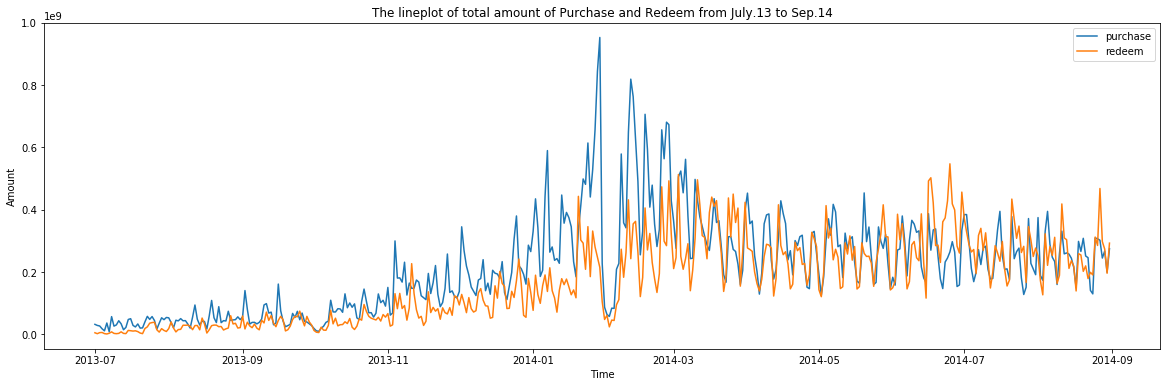

In [11]:
# 画出每日总购买与赎回量的时间序列图

fig = plt.figure(figsize=(20,6))
plt.plot(total_balance['date'], total_balance['total_purchase_amt'],label='purchase')
plt.plot(total_balance['date'], total_balance['total_redeem_amt'],label='redeem')

plt.legend(loc='best')
plt.title("The lineplot of total amount of Purchase and Redeem from July.13 to Sep.14")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

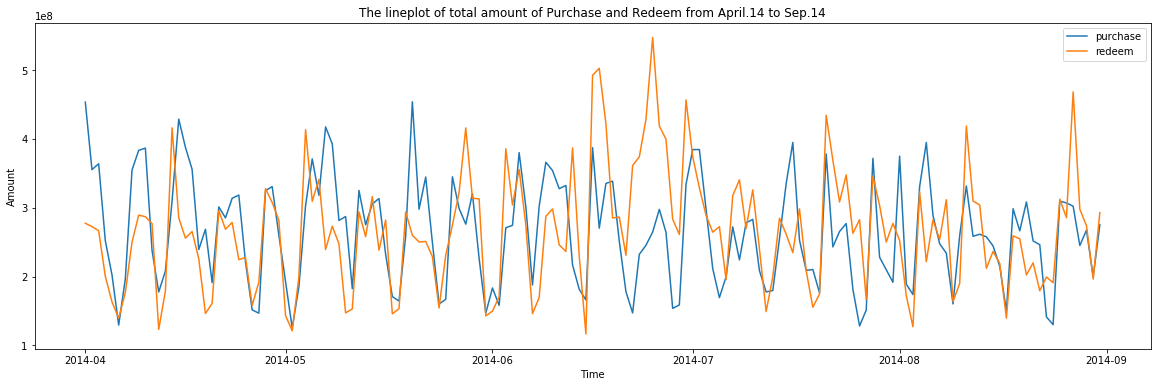

In [12]:
# 画出4月份以后的时间序列图

total_balance_1 = total_balance[total_balance['date'] >= datetime.date(2014,4,1)]
fig = plt.figure(figsize=(20,6))
plt.plot(total_balance_1['date'], total_balance_1['total_purchase_amt'],label='purchase')
plt.plot(total_balance_1['date'], total_balance_1['total_redeem_amt'],label='redeem')

plt.legend(loc='best')
plt.title("The lineplot of total amount of Purchase and Redeem from April.14 to Sep.14")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

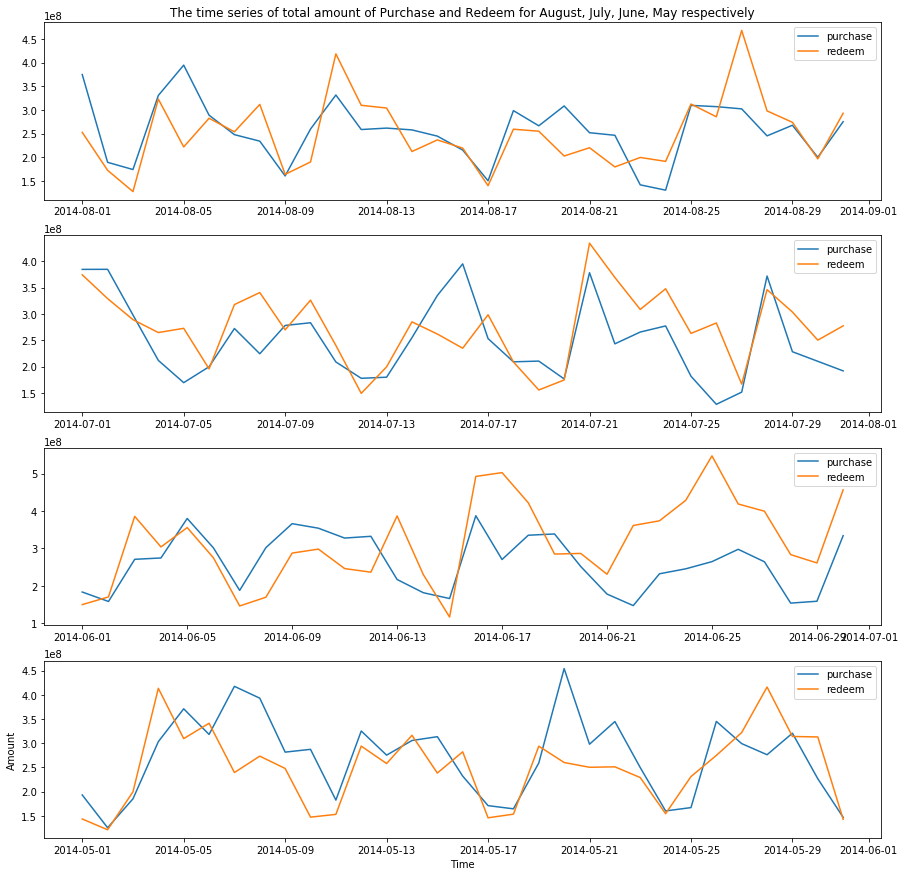

In [13]:
# 分别画出每个月中每天购买赎回量的时间序列图

fig = plt.figure(figsize=(15,15))

plt.subplot(4,1,1)
plt.title("The time series of total amount of Purchase and Redeem for August, July, June, May respectively")

total_balance_2 = total_balance[total_balance['date'] >= datetime.date(2014,8,1)]
plt.plot(total_balance_2['date'], total_balance_2['total_purchase_amt'],label='purchase')
plt.plot(total_balance_2['date'], total_balance_2['total_redeem_amt'],label='redeem')
plt.legend(loc='best')

total_balance_3 = total_balance[(total_balance['date'] >= datetime.date(2014,7,1)) & (total_balance['date'] < datetime.date(2014,8,1))]
plt.subplot(4,1,2)
plt.plot(total_balance_3['date'], total_balance_3['total_purchase_amt'],label='purchase')
plt.plot(total_balance_3['date'], total_balance_3['total_redeem_amt'],label='redeem')
plt.legend(loc='best')


total_balance_4 = total_balance[(total_balance['date'] >= datetime.date(2014,6,1)) & (total_balance['date'] < datetime.date(2014,7,1))]
plt.subplot(4,1,3)
plt.plot(total_balance_4['date'], total_balance_4['total_purchase_amt'],label='purchase')
plt.plot(total_balance_4['date'], total_balance_4['total_redeem_amt'],label='redeem')
plt.legend(loc='best')


total_balance_5 = total_balance[(total_balance['date'] >= datetime.date(2014,5,1)) & (total_balance['date'] < datetime.date(2014,6,1))]
plt.subplot(4,1,4)
plt.plot(total_balance_5['date'], total_balance_5['total_purchase_amt'],label='purchase')
plt.plot(total_balance_5['date'], total_balance_5['total_redeem_amt'],label='redeem')
plt.legend(loc='best')

plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

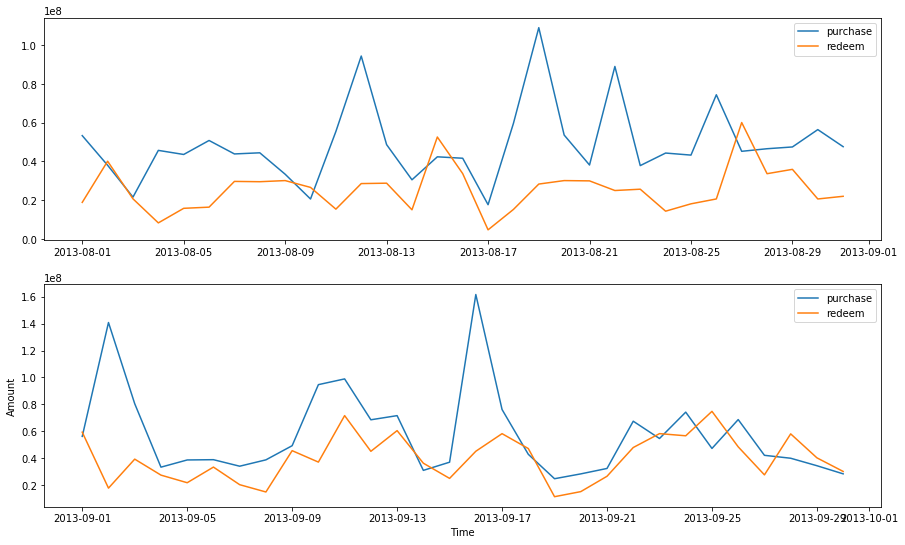

In [14]:
# 分别画出13年8月与9月每日购买赎回量的时序图

fig = plt.figure(figsize=(15,9))

total_balance_last8 = total_balance[(total_balance['date'] >= datetime.date(2013,8,1)) & (total_balance['date'] < datetime.date(2013,9,1))]
plt.subplot(2,1,1)
plt.plot(total_balance_last8['date'], total_balance_last8['total_purchase_amt'],label='purchase')
plt.plot(total_balance_last8['date'], total_balance_last8['total_redeem_amt'],label='redeem')
plt.legend()

total_balance_last9 = total_balance[(total_balance['date'] >= datetime.date(2013,9,1)) & (total_balance['date'] < datetime.date(2013,10,1))]
plt.subplot(2,1,2)
plt.plot(total_balance_last9['date'], total_balance_last9['total_purchase_amt'],label='purchase')
plt.plot(total_balance_last9['date'], total_balance_last9['total_redeem_amt'],label='redeem')
plt.legend()

plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

## 二、周特征分析

从数据分布来看周日到周三的购买量和赎回量集中在2到4之间，周四到周六集中在1-3之间，并且前者的中位数也明显高于后者(赎回量周四同周日到周三)；说明用户更喜欢在周初交易。另外购买量均匀分布在1.5到3.5之间,赎回量则更集中在2到3之间(单位100000000分)。

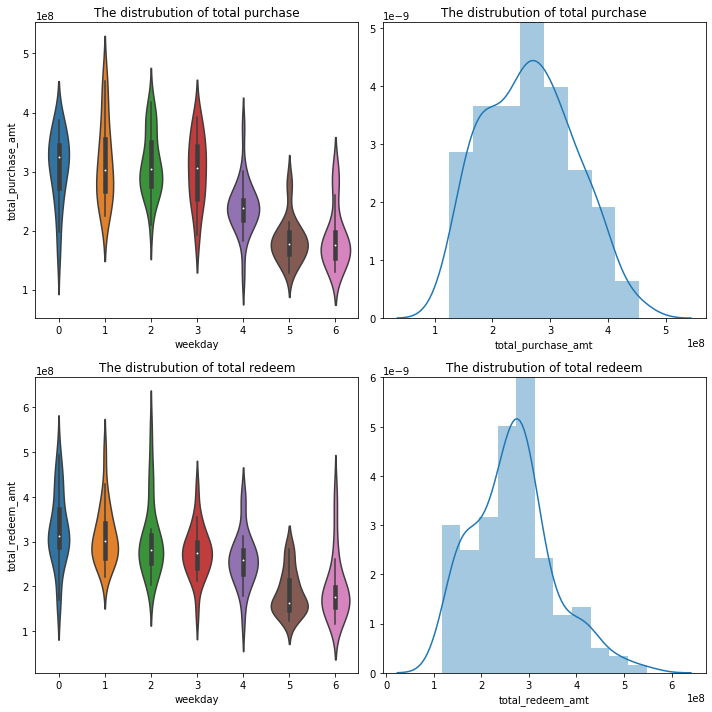

In [15]:
# 画出每个翌日的数据分布于整体数据的分布图

a = plt.figure(figsize=(10,10))
scatter_para = {'marker':'.', 's':3, 'alpha':0.3}
line_kws = {'color':'k'}
plt.subplot(2,2,1)
plt.title('The distrubution of total purchase')
sns.violinplot(x='weekday', y='total_purchase_amt', data = total_balance_1, scatter_kws=scatter_para, line_kws=line_kws)
plt.subplot(2,2,2)
plt.title('The distrubution of total purchase')
sns.distplot(total_balance_1['total_purchase_amt'].dropna())
plt.subplot(2,2,3)
plt.title('The distrubution of total redeem')
sns.violinplot(x='weekday', y='total_redeem_amt', data = total_balance_1, scatter_kws=scatter_para, line_kws=line_kws)
plt.subplot(2,2,4)
plt.title('The distrubution of total redeem')
sns.distplot(total_balance_1['total_redeem_amt'].dropna())
plt.tight_layout()#会自动调整子图参数，使之填充整个图像区域

In [16]:
# 按星期对数据聚合后取均值

week_sta = total_balance_1[['total_purchase_amt', 'total_redeem_amt', 'weekday']].groupby('weekday', as_index=False).mean()

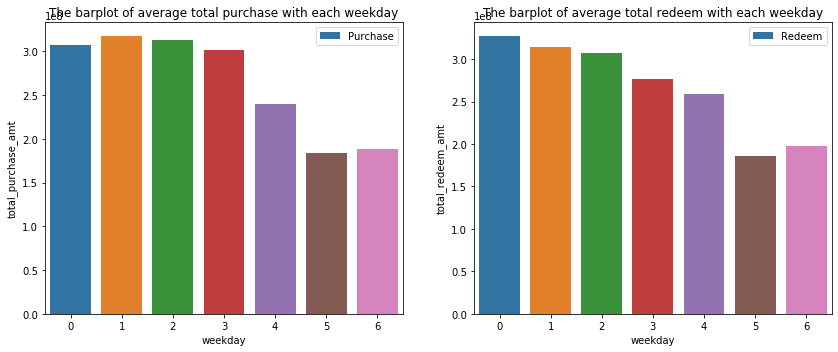

In [17]:
# 分析翌日的中位数特征

plt.figure(figsize=(12, 5))
ax = plt.subplot(1,2,1)
plt.title('The barplot of average total purchase with each weekday')
ax = sns.barplot(x="weekday", y="total_purchase_amt", data=week_sta, label='Purchase')
ax.legend()
ax = plt.subplot(1,2,2)
plt.title('The barplot of average total redeem with each weekday')
ax = sns.barplot(x="weekday", y="total_redeem_amt", data=week_sta, label='Redeem')
ax.legend()
plt.tight_layout()

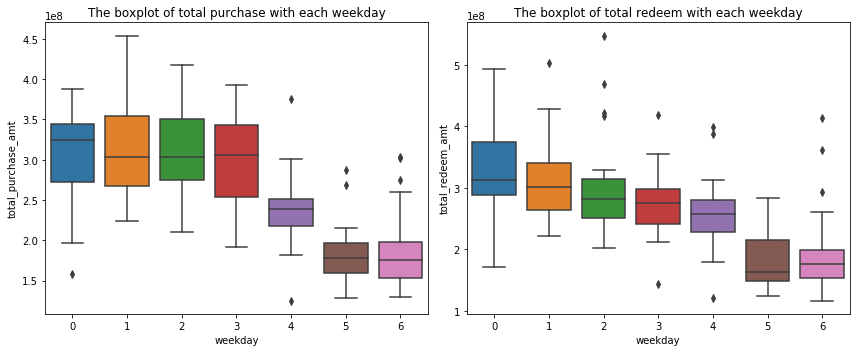

In [18]:
# 画出翌日的箱型图
plt.figure(figsize=(12, 5))
ax = plt.subplot(1,2,1)
plt.title('The boxplot of total purchase with each weekday')
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=total_balance_1)
ax = plt.subplot(1,2,2)
plt.title('The boxplot of total redeem with each weekday')
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=total_balance_1)
plt.tight_layout()

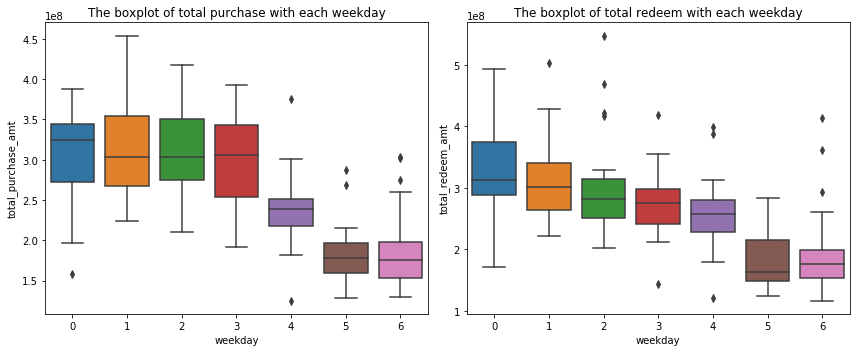

In [19]:
# 画出翌日的箱型图
plt.figure(figsize=(12, 5))
ax = plt.subplot(1,2,1)
plt.title('The boxplot of total purchase with each weekday')
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=total_balance_1)
ax = plt.subplot(1,2,2)
plt.title('The boxplot of total redeem with each weekday')
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=total_balance_1)
plt.tight_layout()

In [20]:
# 使用OneHot方法将星期特征划分，获取划分后特征
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
total_balance = total_balance.reset_index()
week_feature = encoder.fit_transform(np.array(total_balance['weekday']).reshape(-1, 1)).toarray()
week_feature = pd.DataFrame(week_feature,columns=['weekday_onehot']*len(week_feature[0]))
feature = pd.concat([total_balance, week_feature], axis = 1)[['total_purchase_amt', 'total_redeem_amt','weekday_onehot','date']]
feature.columns = list(feature.columns[0:2]) + [x+str(i) for i,x in enumerate(feature.columns[2:-1])] + ['date']

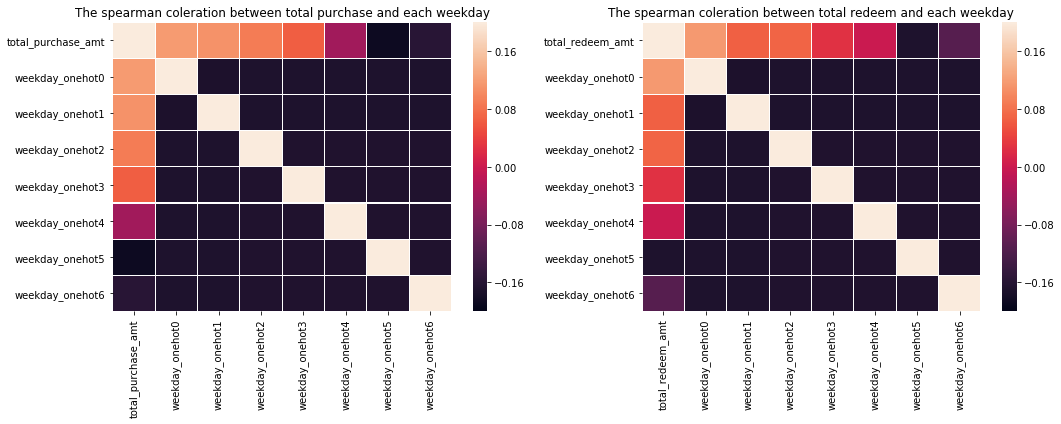

In [21]:
# 画出划分后星期特征与标签的斯皮尔曼相关性
f, ax = plt.subplots(figsize = (15, 6))
plt.subplot(1,2,1)
plt.title('The spearman coleration between total purchase and each weekday')
sns.heatmap(feature[[x for x in feature.columns if x not in ['total_redeem_amt', 'date'] ]].corr('spearman'),linewidths = 0.1, vmax = 0.2, vmin=-0.2)
plt.subplot(1,2,2)
plt.title('The spearman coleration between total redeem and each weekday')
sns.heatmap(feature[[x for x in feature.columns if x not in ['total_purchase_amt', 'date'] ]].corr('spearman'),linewidths = 0.1,  vmax = 0.2, vmin=-0.2)
plt.tight_layout()

相关热力图显示购买量与赎回量都和周日到周三正相关，和周四到周六负相关。并且在周日达到正相关系数最大值0.16左右，周五达到负相关系数最大值-0.16左右。均是若相关性。

In [22]:
# 测试翌日特征与标签的独立性 Ref: https://github.com/ChuanyuXue/MVTest
from mvtpy.mvtest import mvtest
mv = mvtest()
mv.test(total_balance_1['total_purchase_amt'], total_balance_1['weekday'])
做方差分析？

SyntaxError: invalid character in identifier (<ipython-input-22-6054b7f18e69>, line 5)

## 三、月份特征分析
随着时间变化购买量和赎回量的箱线图上移，即都变大。从购买量来看14年2月份整体最高，然后降低到一个比较稳定的水平；赎回量14年3月份略微上涨然后保持和购买持平；购买量和赎回量相比在14年3月份以前都是购买量更大,3月份到5月份差异不大，6月和7月赎回量反超，8月份又基本持平。

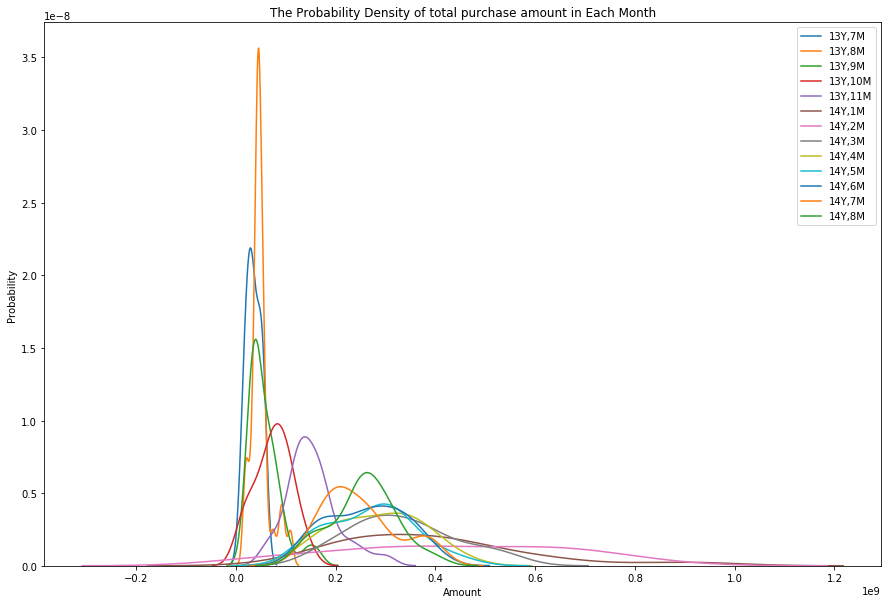

In [24]:
# 画出每个月的购买总量分布估计图(kdeplot)

plt.figure(figsize=(15,10))
plt.title('The Probability Density of total purchase amount in Each Month')
plt.ylabel('Probability')
plt.xlabel('Amount')
for i in range(7, 12):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2013,i,1)) & (total_balance['date'] < datetime.date(2013,i+1,1))]['total_purchase_amt'],label='13Y,'+str(i)+'M')
for i in range(1, 9):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2014,i,1)) & (total_balance['date'] < datetime.date(2014,i+1,1))]['total_purchase_amt'],label='14Y,'+str(i)+'M')

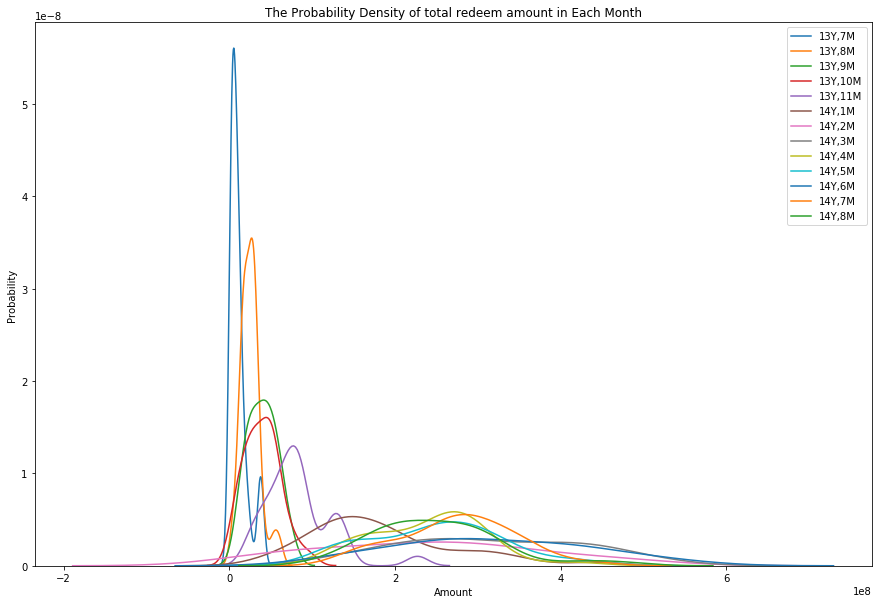

In [25]:
# 画出每个月的赎回总量分布估计图(kdeplot)

plt.figure(figsize=(15,10))
plt.title('The Probability Density of total redeem amount in Each Month')
plt.ylabel('Probability')
plt.xlabel('Amount')
for i in range(7, 12):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2013,i,1)) & (total_balance['date'] < datetime.date(2013,i+1,1))]['total_redeem_amt'],label='13Y,'+str(i)+'M')
for i in range(1, 9):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2014,i,1)) & (total_balance['date'] < datetime.date(2014,i+1,1))]['total_redeem_amt'],label='14Y,'+str(i)+'M')

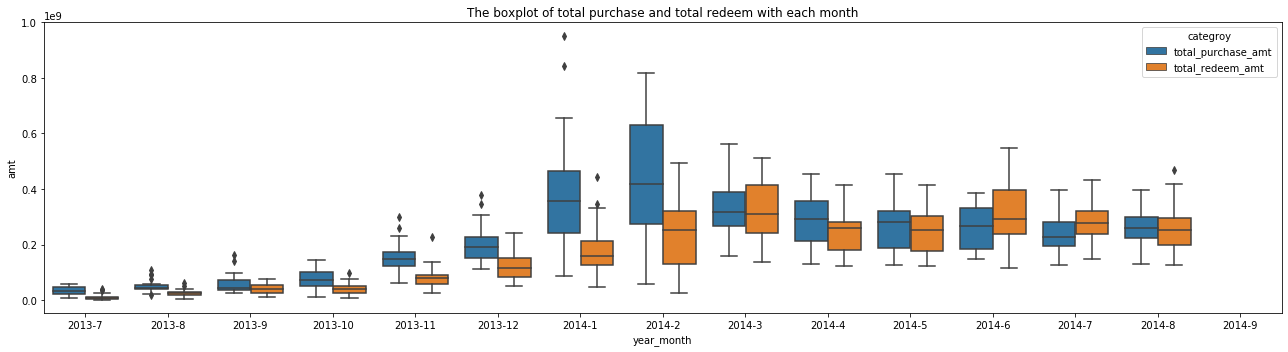

In [26]:
total_balance['year_month']=total_balance['year'].map(str)+'-'+total_balance['month'].map(str)
total_balance_6=total_balance[['year_month','total_purchase_amt']]
total_balance_6['categroy']='total_purchase_amt'
total_balance_6.columns=['year_month','amt','categroy']#修改全部列名
total_balance_7=total_balance[['year_month','total_redeem_amt']]
total_balance_7['categroy']='total_redeem_amt'
total_balance_7.columns=['year_month','amt','categroy']#修改全部列名
total_balance_8=pd.concat([total_balance_6,total_balance_7],ignore_index=True)
#绘制提琴图
plt.figure(figsize=(18, 5))
plt.title('The boxplot of total purchase and total redeem with each month')
sns.boxplot(data=total_balance_8,x='year_month',y='amt',hue='categroy')#,hue=''最合适的用二分类变量
plt.tight_layout()

## 四、每天特征分析

直方图显示在在周初倾向于存钱，周中期倾向于赎回。

In [27]:
# 按照每天聚合数据集（14年8月份）

day_sta = total_balance_2[['total_purchase_amt', 'total_redeem_amt', 'day']].groupby('day', as_index=False).mean()

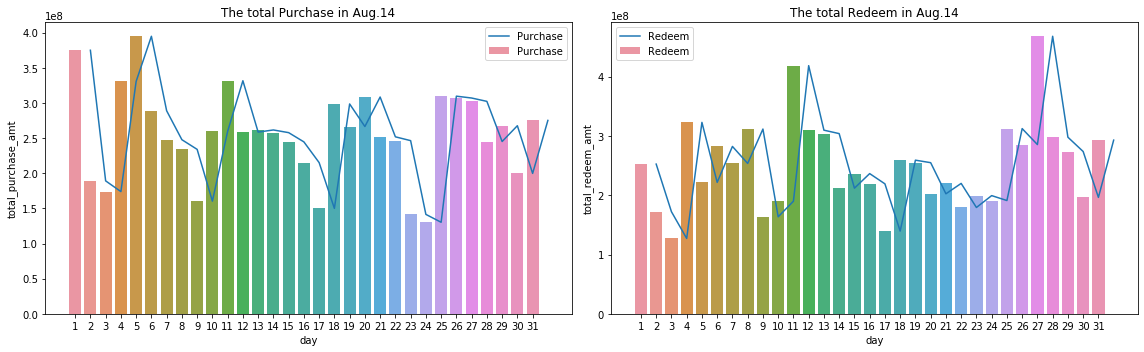

In [28]:
plt.figure(figsize=(16, 5))

# 获取聚合后每月购买分布的柱状图
ax = plt.subplot(1,2,1)
ax = sns.barplot(x="day", y="total_purchase_amt", data=day_sta, label='Purchase')
ax = sns.lineplot(x="day", y="total_purchase_amt", data=day_sta, label='Purchase')
ax.legend()
plt.title("The total Purchase in Aug.14")

# 获取聚合后每月赎回分布的柱状图
ax = plt.subplot(1,2,2)
ax = sns.barplot(x="day", y="total_redeem_amt", data=day_sta, label='Redeem')
ax = sns.lineplot(x="day", y="total_redeem_amt", data=day_sta, label='Redeem')
ax.legend()
plt.title("The total Redeem in Aug.14")
plt.tight_layout()

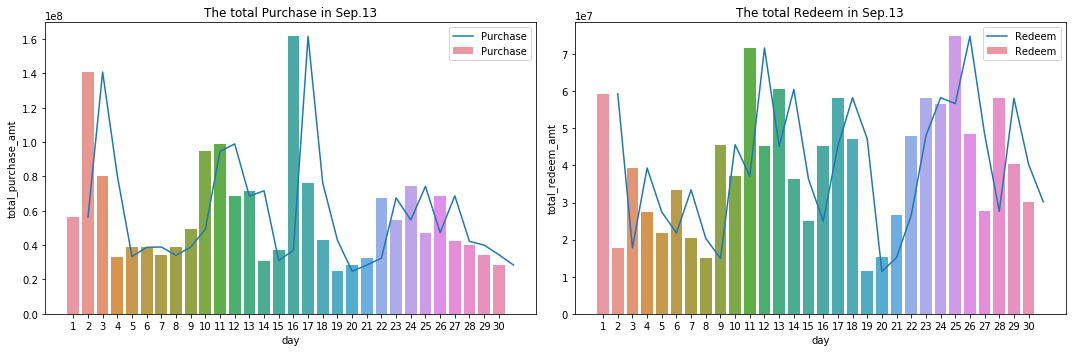

In [29]:
# 画出13年九月份的分布图
total_balance_last_7 = total_balance[(total_balance['date'] >= datetime.date(2013,7,1)) & (total_balance['date'] < datetime.date(2013,8,1))]
total_balance_last_8 = total_balance[(total_balance['date'] >= datetime.date(2013,8,1)) & (total_balance['date'] < datetime.date(2013,9,1))]
total_balance_last_9 = total_balance[(total_balance['date'] >= datetime.date(2013,9,1)) & (total_balance['date'] < datetime.date(2013,10,1))]
total_balance_last_10 = total_balance[(total_balance['date'] >= datetime.date(2013,10,1)) & (total_balance['date'] < datetime.date(2013,11,1))]
plt.figure(figsize=(15,5))
day_sta = total_balance_last_9[['total_purchase_amt', 'total_redeem_amt', 'day']].groupby('day', as_index=False).mean()
plt.subplot(1,2,1)
plt.title("The total Purchase in Sep.13")
ax = sns.barplot(x="day", y="total_purchase_amt", data=day_sta, label='Purchase')
ax = sns.lineplot(x="day", y="total_purchase_amt", data=day_sta, label='Purchase')
plt.subplot(1,2,2)
plt.title("The total Redeem in Sep.13")
bx = sns.barplot(x="day", y="total_redeem_amt", data=day_sta, label='Redeem')
bx = sns.lineplot(x="day", y="total_redeem_amt", data=day_sta, label='Redeem')
bx.legend()
plt.tight_layout()

**We find that the data from last year in Sep has very limited week feature**

There are some strange day in Sep:

1. 1st day
2. 2nd day
3. 16th day(Purchase a lot)---Monday & 3days before MidAutumn Festirval
4. 11th day and 25th day(Redeem a lot)---Both of Wednesday
5. 18 19 20(Both Purchase and Redeem is very low)

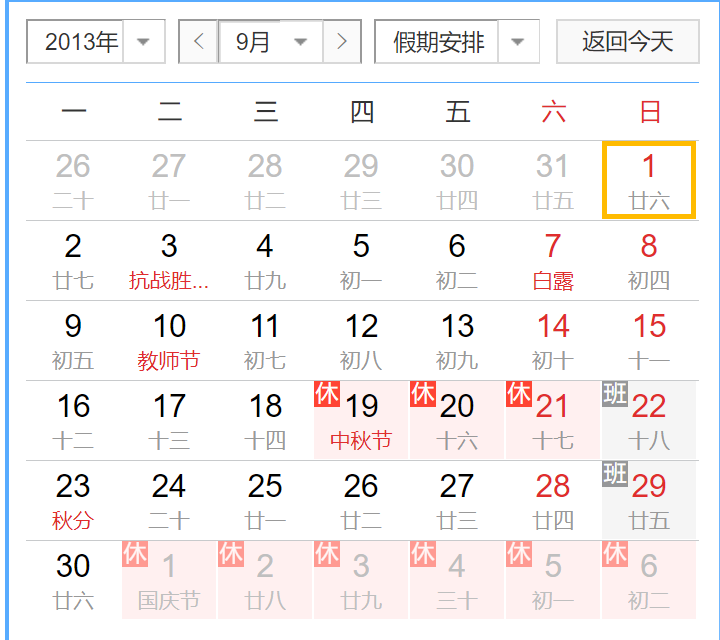

Text(69.0, 0.5, 'week')

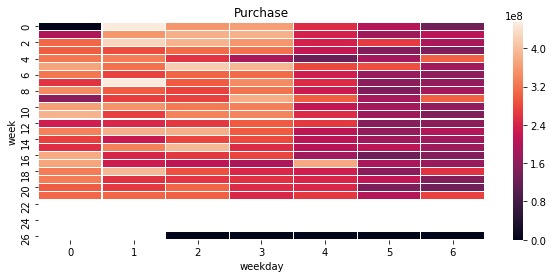

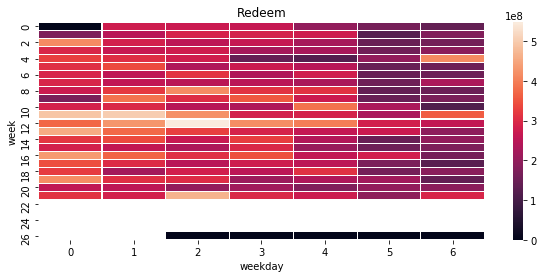

In [30]:
# 画出历史所有天的热力图

test = np.zeros((max(total_balance_1['week']) - min(total_balance_1['week']) + 1, 7))
test[total_balance_1['week'] - min(total_balance_1['week']), total_balance_1['weekday']] = total_balance_1['total_purchase_amt']

f, ax = plt.subplots(figsize = (10, 4))
sns.heatmap(test,linewidths = 0.1, ax=ax)
ax.set_title("Purchase")
ax.set_xlabel('weekday')
ax.set_ylabel('week')

test = np.zeros((max(total_balance_1['week']) - min(total_balance_1['week']) + 1, 7))
test[total_balance_1['week'] - min(total_balance_1['week']), total_balance_1['weekday']] = total_balance_1['total_redeem_amt']

f, ax = plt.subplots(figsize = (10, 4))
sns.heatmap(test,linewidths = 0.1, ax=ax)
ax.set_title("Redeem")
ax.set_xlabel('weekday')
ax.set_ylabel('week')

From the heat map we find that the data of week 4 and weekday 6 is very strange, and week 12 weekday 2 either
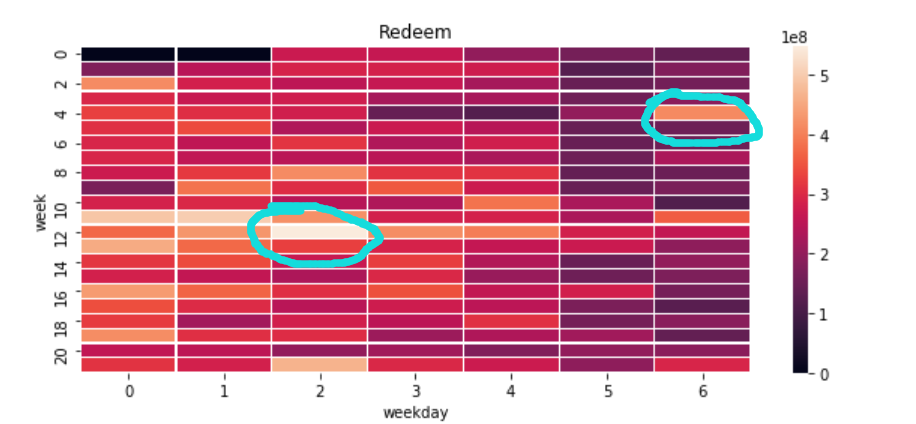

In [31]:
# 对于热力图中异常点的数据分析.1

total_balance_1[(total_balance_1['week'] == 4 + min(total_balance_1['week'])) & (total_balance_1['weekday'] == 6)]

,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
307,2014-05-04,303087562.0,413222034.0,4,5,2014,18,6


**2014-5-4 is a special day in China, It is the first workday after the Labour day!**
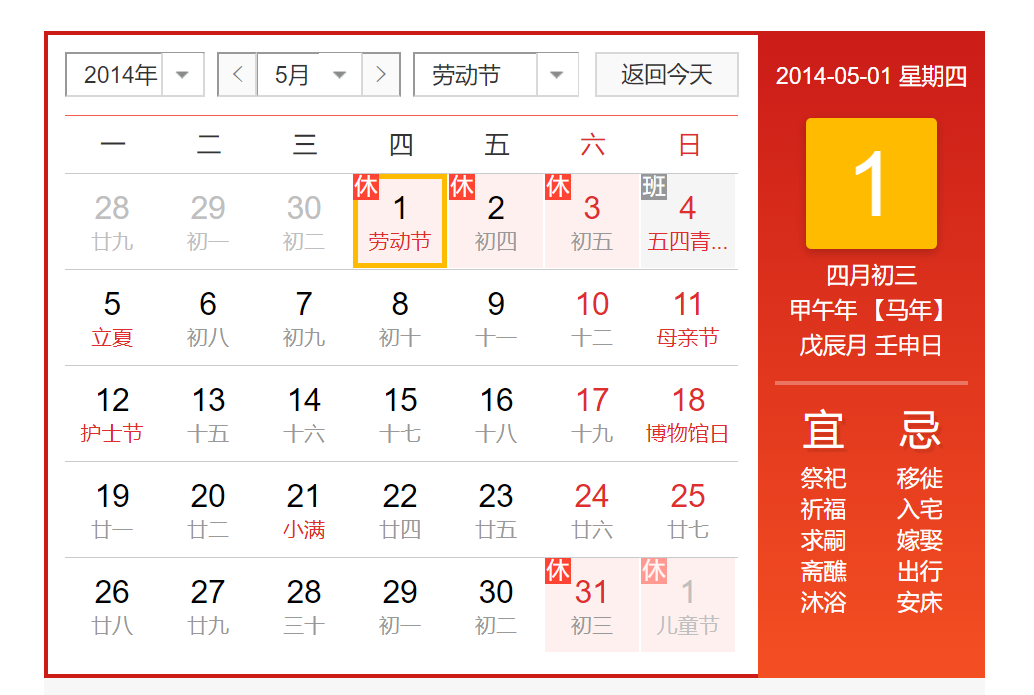

In [32]:
# 对于热力图中异常点的数据分析.2

total_balance_1[(total_balance_1['week'] == 12 + min(total_balance_1['week'])) & (total_balance_1['weekday'] == 2)]

,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
359,2014-06-25,264663201.0,547295931.0,25,6,2014,26,2


In 2014-06-25 They Redeemed a lot but Purchase a little:
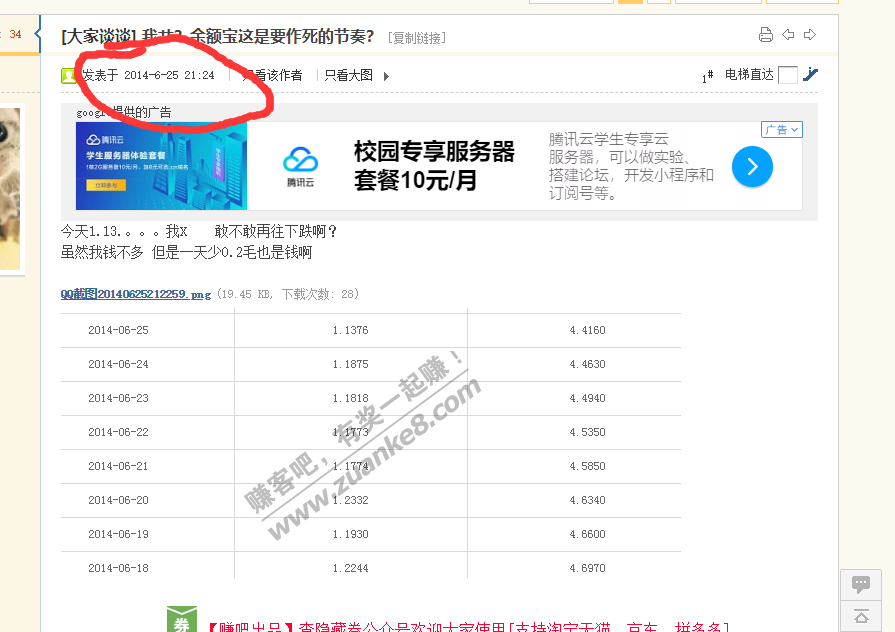

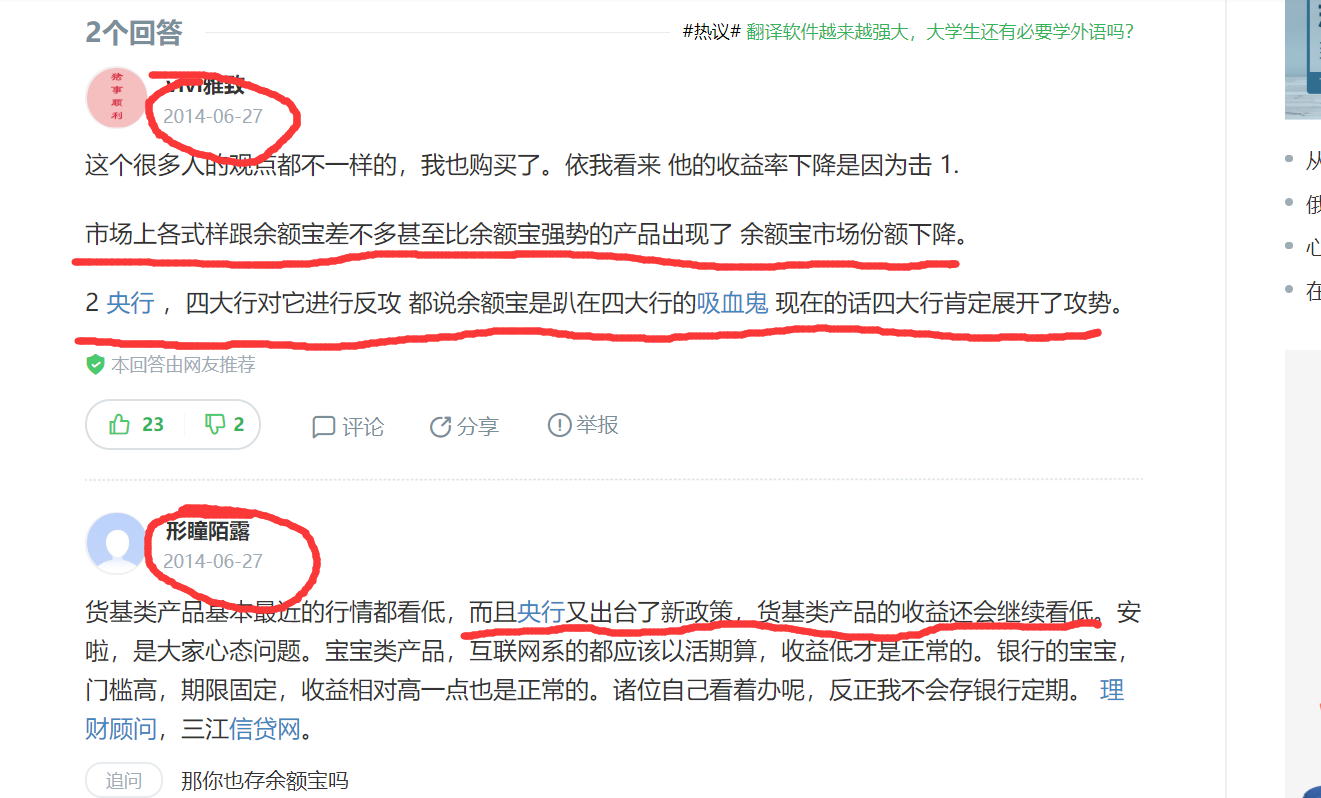

## 五、对于节假期的分析

清明、劳动、端午三个节日的交易量明显低于平时的均值，618活动是交易量要高于平时的均值.

取与节假日相同的时间段相比(三天)交易量也明显低于平时。

In [33]:
# 获取节假日的数据

qingming = total_balance[(total_balance['date'] >= datetime.date(2014,4,5)) & (total_balance['date'] < datetime.date(2014,4,8))]
labour = total_balance[(total_balance['date'] >= datetime.date(2014,5,1)) & (total_balance['date'] < datetime.date(2014,5,4))]
duanwu = total_balance[(total_balance['date'] >= datetime.date(2014,5,31)) & (total_balance['date'] < datetime.date(2014,6,3))]
data618 = total_balance[(total_balance['date'] >= datetime.date(2014,6,10)) & (total_balance['date'] < datetime.date(2014,6,20))]

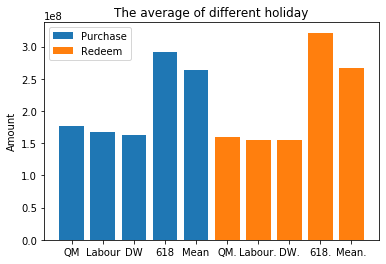

In [34]:
# 画出节假日与平时的均值

fig = plt.figure()
index_list = ['QM','Labour','DW','618','Mean']
label_list = [np.mean(qingming['total_purchase_amt']), np.mean(labour['total_purchase_amt']),np.mean(duanwu['total_purchase_amt']),np.mean(data618['total_purchase_amt']),np.mean(total_balance_1['total_purchase_amt'])]
plt.bar(index_list, label_list, label="Purchase")

index_list = ['QM.','Labour.','DW.','618.','Mean.']
label_list = [np.mean(qingming['total_redeem_amt']), np.mean(labour['total_redeem_amt']),np.mean(duanwu['total_redeem_amt']),np.mean(data618['total_redeem_amt']),np.mean(total_balance_1['total_redeem_amt'])]
plt.bar(index_list, label_list, label="Redeem")
plt.title("The average of different holiday")
plt.ylabel("Amount")
plt.legend()
plt.show()

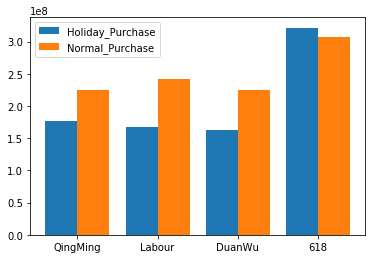

In [35]:
# 画出节假日购买量与其所处翌日的对比

import numpy as np
import matplotlib.pyplot as plt
size = 4
x = np.arange(size)

total_width, n = 0.8, 2    
width = total_width / n
x = x - (total_width - width) / 2

a = [176250006, 167825284, 162844282,321591063]
b = [225337516, 241859315, 225337516,307635449]

plt.bar(x, a,  width=width, label='Holiday_Purchase')
plt.bar(x + width, b, width=width, label='Normal_Purchase')
plt.xticks(x + width / 2, ('QingMing', 'Labour', 'DuanWu', '618'))
plt.legend()
plt.show()

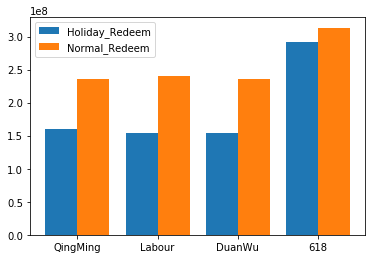

In [36]:
# 画出节假日赎回量与其所处翌日的对比

import numpy as np
import matplotlib.pyplot as plt
size = 4
x = np.arange(size)

total_width, n = 0.8, 2     
width = total_width / n
x = x - (total_width - width) / 2

a = [159914308, 154717620, 154366940,291016763]
b = [235439685, 240364238, 235439685,313310347]

plt.bar(x, a,  width=width, label='Holiday_Redeem')
plt.bar(x + width, b, width=width, label='Normal_Redeem')
plt.xticks(x + width / 2, ('QingMing', 'Labour', 'DuanWu', '618'))
plt.legend()
plt.show()

## 六、对于节假日周边日期的分析

临近节假日交易量会下架后上涨，节假日交易量最低。

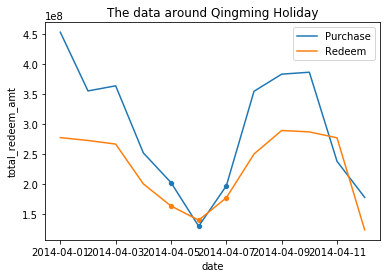

In [37]:
# 画出清明节与周边日期的时序图

qingming_around = total_balance[(total_balance['date'] >= datetime.date(2014,4,1)) & (total_balance['date'] < datetime.date(2014,4,13))]
ax = sns.lineplot(x="date", y="total_purchase_amt", data=qingming_around, label='Purchase')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=qingming_around, label='Redeem', ax=ax)
ax = sns.scatterplot(x="date", y="total_purchase_amt", data=qingming, ax=ax)
ax = sns.scatterplot(x="date", y="total_redeem_amt", data=qingming, ax=ax)
plt.title("The data around Qingming Holiday")
ax.legend()

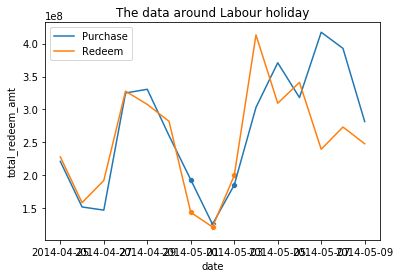

In [38]:
# 画出劳动节与周边日期的时序图

labour_around = total_balance[(total_balance['date'] >= datetime.date(2014,4,25)) & (total_balance['date'] < datetime.date(2014,5,10))]
ax = sns.lineplot(x="date", y="total_purchase_amt", data=labour_around, label='Purchase')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=labour_around, label='Redeem', ax=ax)
ax = sns.scatterplot(x="date", y="total_purchase_amt", data=labour, ax=ax)
ax = sns.scatterplot(x="date", y="total_redeem_amt", data=labour, ax=ax)
plt.title("The data around Labour holiday")
ax.legend()

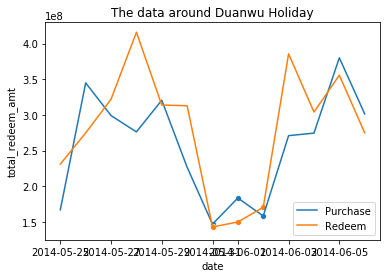

In [39]:
# # 画出端午节与周边日期的时序图

duanwu_around = total_balance[(total_balance['date'] >= datetime.date(2014,5,25)) & (total_balance['date'] < datetime.date(2014,6,7))]
ax = sns.lineplot(x="date", y="total_purchase_amt", data=duanwu_around, label='Purchase')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=duanwu_around, label='Redeem', ax=ax)
ax = sns.scatterplot(x="date", y="total_purchase_amt", data=duanwu, ax=ax)
ax = sns.scatterplot(x="date", y="total_redeem_amt", data=duanwu, ax=ax)
plt.title("The data around Duanwu Holiday")
ax.legend()

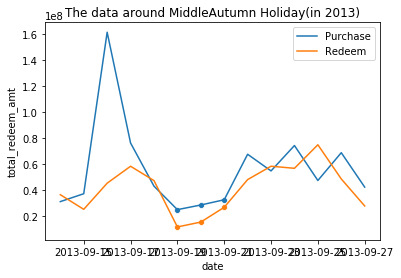

In [40]:
# 画出中秋与周边日期的时序图

zhongqiu = total_balance[(total_balance['date'] >= datetime.date(2013,9,19)) & (total_balance['date'] < datetime.date(2013,9,22))]
zhongqiu_around = total_balance[(total_balance['date'] >= datetime.date(2013,9,14)) & (total_balance['date'] < datetime.date(2013,9,28))]
ax = sns.lineplot(x="date", y="total_purchase_amt", data=zhongqiu_around, label='Purchase')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=zhongqiu_around, label='Redeem', ax=ax)
ax = sns.scatterplot(x="date", y="total_purchase_amt", data=zhongqiu, ax=ax)
ax = sns.scatterplot(x="date", y="total_redeem_amt", data=zhongqiu, ax=ax)
plt.title("The data around MiddleAutumn Holiday(in 2013)")
ax.legend()

## 七、对于异常值的分析

2013年11月4号出现单个用户购买2e8的最高交易记录,该用户当天赎回约1/2的金额，在1个月后又赎回了接近1/2的金额。之后又进行了多次小额购买，2014年6月赎回了1e8的金额。

2e8的交易额(分析下当天占比)11月4号的总交易额要高于周边几天的总交易额；随着总交易额的上升，单个大交易额对总交易额的影响变小。

2014年1-3月超过1e8的交易次数最多。

大额交易（大于100万）购买大于赎回，14年5月出现了赎回大于购买的情况；小额交易购买一直大于赎回。两种交易在周五和周六时都比较低。

Text(0.5, 1.0, 'The abnormal value of total purchase')

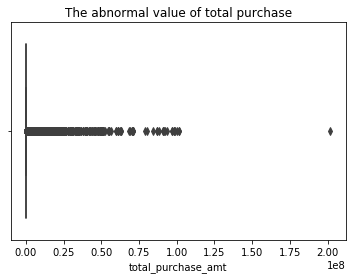

In [41]:
# 画出用户交易纪录的箱型图

sns.boxplot(data_balance['total_purchase_amt'])
plt.title("The abnormal value of total purchase")

In [42]:
# 对于购买2e8的用户的交易行为分析

data_balance[data_balance['user_id'] == 14592].sort_values(by = 'total_redeem_amt',axis = 0,ascending = False).head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,category1,category2,category3,category4,date,day,month,year,week,weekday
1453311,14592,20131104,99457728,0,201768328,201768328,201275171,493157,102310600,0,...,NaN,NaN,NaN,NaN,2013-11-04,4,11,2013,45,0
1453388,14592,20140616,0,98964529,1966014,1953569,0,1953569,100930543,0,...,NaN,NaN,NaN,NaN,2014-06-16,16,6,2014,25,0
1453227,14592,20131226,367063,98296082,17369,0,0,0,97946388,0,...,NaN,NaN,NaN,NaN,2013-12-26,26,12,2013,52,3
1453313,14592,20131105,97458675,99457728,4899446,4899446,4899446,0,6898499,0,...,NaN,NaN,NaN,NaN,2013-11-05,5,11,2013,45,1
1453355,14592,20140617,0,0,339679,339679,0,339679,339679,0,...,NaN,NaN,NaN,NaN,2014-06-17,17,6,2014,25,1


`
1311 Bought 2E Seal 1E
1312        Seal 1E
1405 Bought 0.9E
1406        Seal 1E`

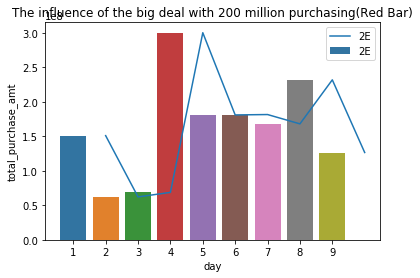

In [43]:
# 画出单笔交易为2e8的那天的总交易量及附近几天的交易量

e2 = total_balance[(total_balance['date'] >= datetime.date(2013,11,1)) & (total_balance['date'] < datetime.date(2013,11,10))]
ax = sns.barplot(x="day", y="total_purchase_amt", data=e2, label='2E')
ax = sns.lineplot(x="day", y="total_purchase_amt", data=e2, label='2E')
plt.title("The influence of the big deal with 200 million purchasing(Red Bar)")
ax.legend()

Text(0.5, 1.0, 'The Biggest deal happend in each day')

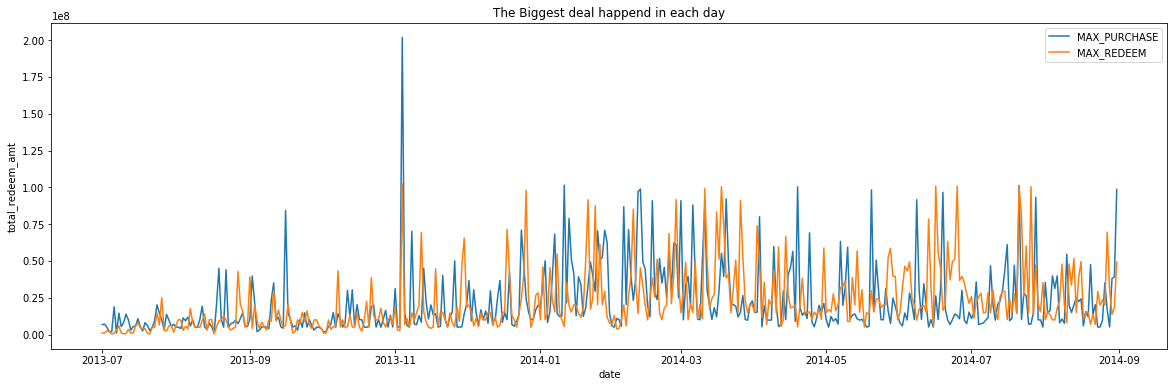

In [44]:
# 画出每日单笔最大交易的时序图

plt.figure(figsize=(20, 6))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).max(), label='MAX_PURCHASE')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=data_balance[['total_redeem_amt', 'date']].groupby('date', as_index=False).max(), label='MAX_REDEEM')
plt.title("The Biggest deal happend in each day")

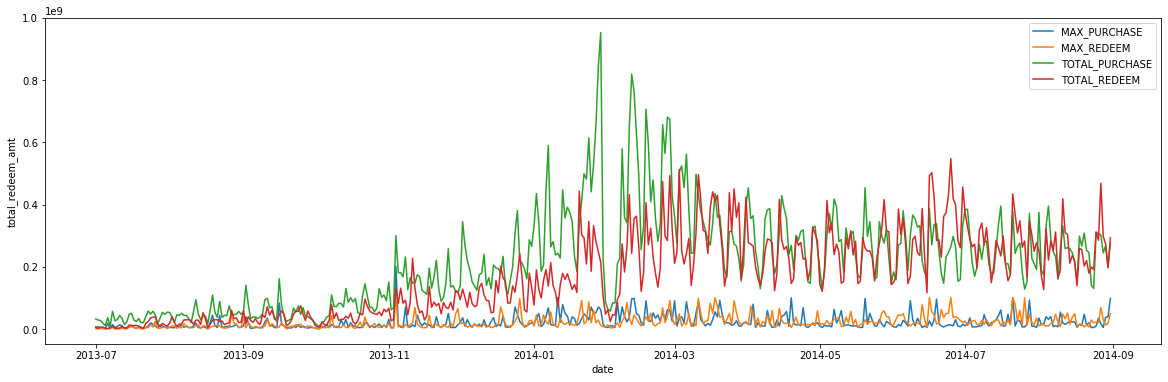

In [45]:
# 画出每日单笔最大交易以及总交易额的时序图

plt.figure(figsize=(20, 6))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).max(), label='MAX_PURCHASE')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=data_balance[['total_redeem_amt', 'date']].groupby('date', as_index=False).max(), label='MAX_REDEEM')
ax = sns.lineplot(x="date", y="total_purchase_amt", data=data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).sum(), label='TOTAL_PURCHASE')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=data_balance[['total_redeem_amt', 'date']].groupby('date', as_index=False).sum(), label='TOTAL_REDEEM')

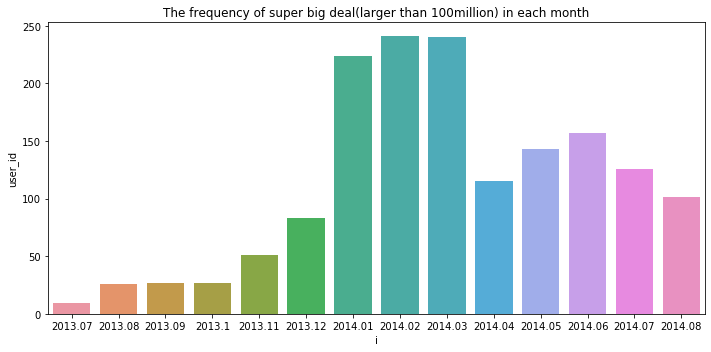

In [46]:
# 画出每个月大额交易的频次直方图

big_frequancy = data_balance[(data_balance['total_purchase_amt'] > 10000000) | (data_balance['total_redeem_amt'] > 10000000)][['month','year','user_id']].groupby(['year','month'], as_index=False).count()
big_frequancy['i'] = big_frequancy['year']  + big_frequancy['month'] / 100
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="i", y="user_id", data=big_frequancy)
plt.title("The frequency of super big deal(larger than 100million) in each month")
plt.tight_layout()

In [47]:
# 获取大额交易的数据集

data_balance['big_purchase'] = 0
data_balance.loc[data_balance['total_purchase_amt'] > 1000000, 'big_purchase'] = 1
data_balance['big_redeem'] = 0
data_balance.loc[data_balance['total_redeem_amt'] > 1000000, 'big_redeem'] = 1

In [48]:
# 对大额交易按每天做聚合操作

big_purchase = data_balance[data_balance['big_purchase'] == 1].groupby(['date'], as_index=False)['total_purchase_amt'].sum()
small_purchase = data_balance[data_balance['big_purchase'] == 0].groupby(['date'], as_index=False)['total_purchase_amt'].sum()
big_redeem = data_balance[data_balance['big_redeem'] == 1].groupby(['date'], as_index=False)['total_redeem_amt'].sum()
small_redeem = data_balance[data_balance['big_redeem'] == 0].groupby(['date'], as_index=False)['total_redeem_amt'].sum()

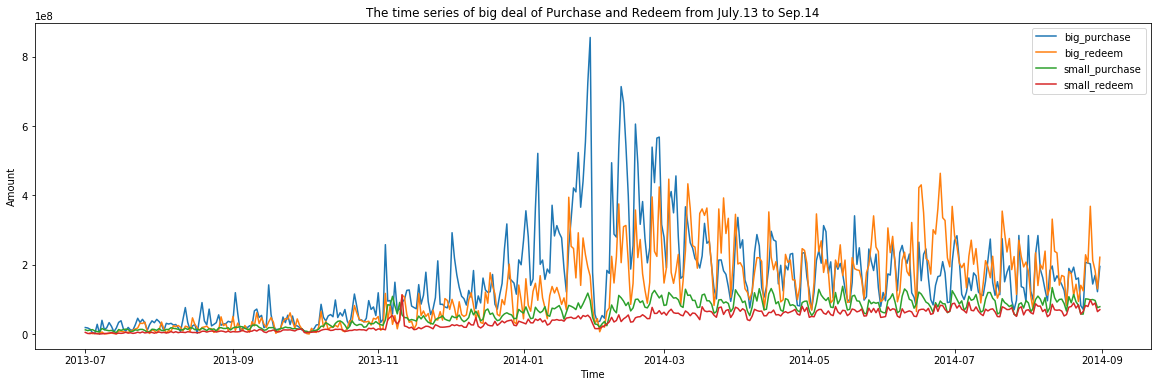

In [49]:
# 画出大额交易与小额交易的时序分布图

fig = plt.figure(figsize=(20,6))
plt.plot(big_purchase['date'], big_purchase['total_purchase_amt'],label='big_purchase')
plt.plot(big_redeem['date'], big_redeem['total_redeem_amt'],label='big_redeem')

plt.plot(small_purchase['date'], small_purchase['total_purchase_amt'],label='small_purchase')
plt.plot(small_redeem['date'], small_redeem['total_redeem_amt'],label='small_redeem')
plt.legend(loc='best')
plt.title("The time series of big deal of Purchase and Redeem from July.13 to Sep.14")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

Text(0.5, 1.0, 'SMALL REDEEM')

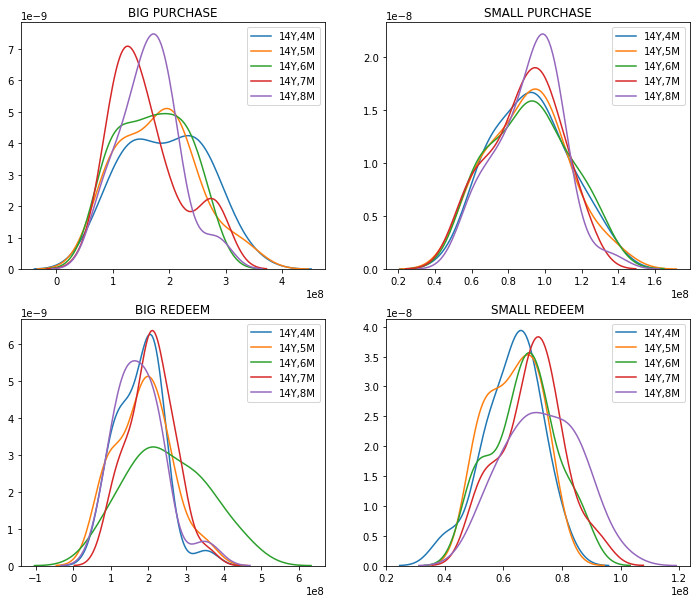

In [70]:
# 画出大额交易与小额交易的分布估计图(不同月份)

plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
for i in range(4, 9):
    sns.kdeplot(big_purchase[(big_purchase['date'] >= datetime.date(2014,i,1)) & (big_purchase['date'] < datetime.date(2014,i+1,1))]['total_purchase_amt'],label='14Y,'+str(i)+'M')
plt.title('BIG PURCHASE')

plt.subplot(2,2,2)
for i in range(4, 9):
    sns.kdeplot(small_purchase[(small_purchase['date'] >= datetime.date(2014,i,1)) & (small_purchase['date'] < datetime.date(2014,i+1,1))]['total_purchase_amt'],label='14Y,'+str(i)+'M')
plt.title('SMALL PURCHASE')

plt.subplot(2,2,3)
for i in range(4, 9):
    sns.kdeplot(big_redeem[(big_redeem['date'] >= datetime.date(2014,i,1)) & (big_redeem['date'] < datetime.date(2014,i+1,1))]['total_redeem_amt'],label='14Y,'+str(i)+'M')
plt.title('BIG REDEEM')

plt.subplot(2,2,4)
for i in range(4, 9):
    sns.kdeplot(small_redeem[(small_redeem['date'] >= datetime.date(2014,i,1)) & (small_redeem['date'] < datetime.date(2014,i+1,1))]['total_redeem_amt'],label='14Y,'+str(i)+'M')
plt.title('SMALL REDEEM')

In [51]:
# 添加时间戳

big_purchase['weekday'] = big_purchase['date'].dt.weekday
small_purchase['weekday'] = small_purchase['date'].dt.weekday
big_redeem['weekday'] = big_redeem['date'].dt.weekday
small_redeem['weekday'] = small_redeem['date'].dt.weekday

Text(0.5, 1.0, 'SMALL REDEEM')

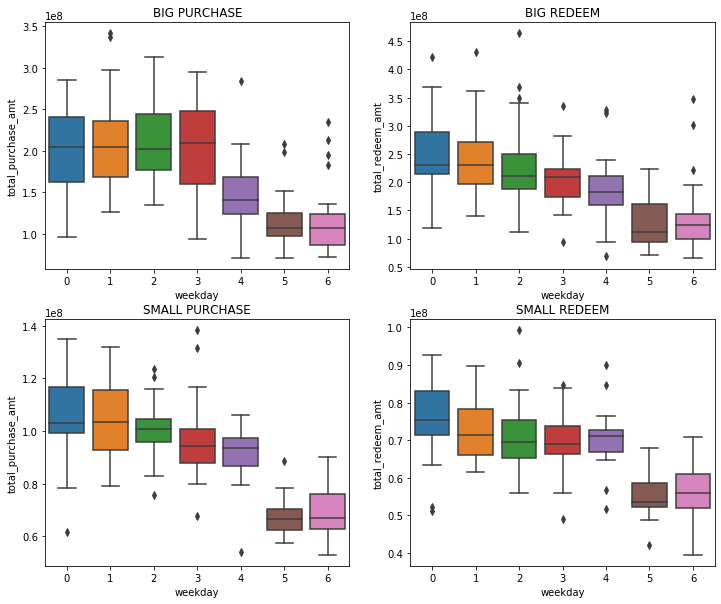

In [52]:
# 分析大额小额的翌日分布

plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=big_purchase[big_purchase['date'] >= datetime.date(2014,4,1)])
plt.title('BIG PURCHASE')

ax = plt.subplot(2,2,2)
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=big_redeem[big_redeem['date'] >= datetime.date(2014,4,1)])
plt.title('BIG REDEEM')

ax = plt.subplot(2,2,3)
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=small_purchase[small_purchase['date'] >= datetime.date(2014,4,1)])
plt.title('SMALL PURCHASE')

ax = plt.subplot(2,2,4)
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=small_redeem[small_redeem['date'] >= datetime.date(2014,4,1)])
plt.title('SMALL REDEEM')

## 八、分析用户交易纪录表中其他变量

从相关性热力图可以看出和总购买量呈正相关的是今日直接购买量，今日银行卡购买量以及今日支付宝购买量；定性来看总购买量和另外三者存在等式关系。

In [53]:
# 截断数据集

data_balance_1 = data_balance[data_balance['date'] > datetime.datetime(2014,4,1)]

Text(0.5, 1, 'The coleration between each feature in User_Balance_Table')

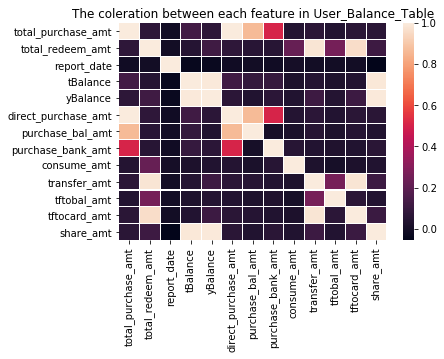

In [54]:
# 画出用户交易纪录表中其他变量与标签的相关性图

feature = ['total_purchase_amt','total_redeem_amt', 'report_date', 'tBalance', 'yBalance', 
       'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt',
        'consume_amt', 'transfer_amt', 'tftobal_amt',
       'tftocard_amt', 'share_amt']

sns.heatmap(data_balance_1[feature].corr(), linewidths = 0.05)   
plt.title("The coleration between each feature in User_Balance_Table")

## 九、对于银行利率的分析

总购买量和赎回量3个月到1年的拆解利率呈正相关，相关系数在0.5至0.75左右，相关度较高；而银行的短期拆解利率和总购买两和赎回量相关性几乎为0（隔夜拆解利率和总购买量和赎回量呈现弱负相关）。

小额总购买量和赎回量和短期拆解利率负相关性更明显（高于-0.25）。大额赎回量和短期拆解利率呈现弱负相关性，购买量则不明显。

短期(3个月以下)银行利率波动较大，长期银行利率在14年年初经历上涨之后比较稳定；其中3个月的拆解利率先上涨后下降。总购买量的变化趋势
和3个月的拆解利率比较一致先上涨后下降；赎回量和长期拆解利率的趋势比较一致上涨之后比较稳定。

In [55]:
# 读取银行利率并添加时间戳

bank = pd.read_csv("mfd_bank_shibor.csv")
bank = bank.rename(columns = {'mfd_date': 'date'})
bank_features = [x for x in bank.columns if x not in ['date']]
bank['date'] = pd.to_datetime(bank['date'], format= "%Y%m%d")
bank['day'] = bank['date'].dt.day
bank['month'] = bank['date'].dt.month
bank['year'] = bank['date'].dt.year
bank['week'] = bank['date'].dt.week
bank['weekday'] = bank['date'].dt.weekday

In [56]:
# 读取支付宝利率并添加时间戳

share = pd.read_csv('mfd_day_share_interest.csv')
share = share.rename(columns = {'mfd_date': 'date'})
share_features = [x for x in share.columns if x not in ['date']]
share['date'] = pd.to_datetime(share['date'], format= "%Y%m%d")
share['day'] = share['date'].dt.day
share['month'] = share['date'].dt.month
share['year'] = share['date'].dt.year
share['week'] = share['date'].dt.week
share['weekday'] = share['date'].dt.weekday

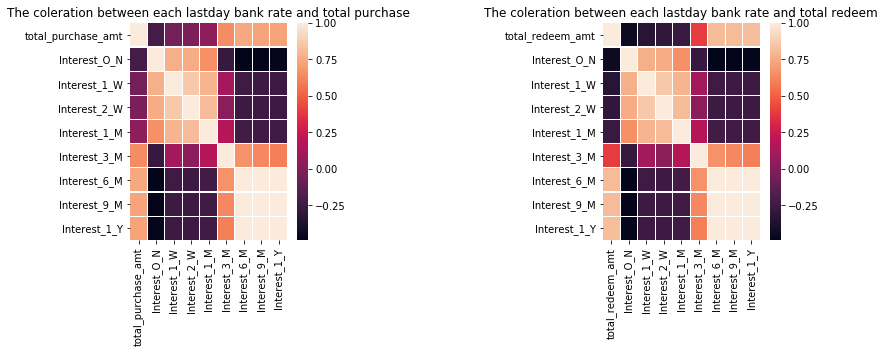

In [57]:
# 画出上一天银行及支付宝利率与标签的相关性图

bank['last_date'] = bank['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("The coleration between each lastday bank rate and total purchase")
temp = pd.merge(bank[['last_date']+bank_features], total_balance, left_on='last_date', right_on='date')[['total_purchase_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  
plt.subplot(1,3,3)
plt.title("The coleration between each lastday bank rate and total redeem")
temp = pd.merge(bank[['last_date']+bank_features], total_balance, left_on='last_date', right_on='date')[['total_redeem_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  

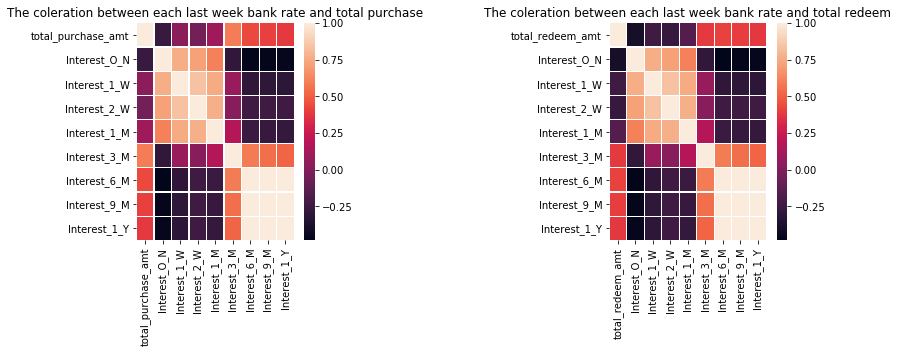

In [71]:
# 画出上一星期银行及支付宝利率与标签的相关性图

bank['last_week'] = bank['week'] + 1
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("The coleration between each last week bank rate and total purchase")
temp = pd.merge(bank[['last_week','weekday']+bank_features], total_balance, left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  
plt.subplot(1,3,3)
plt.title("The coleration between each last week bank rate and total redeem")
temp = pd.merge(bank[['last_week','weekday']+bank_features], total_balance, left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05) 

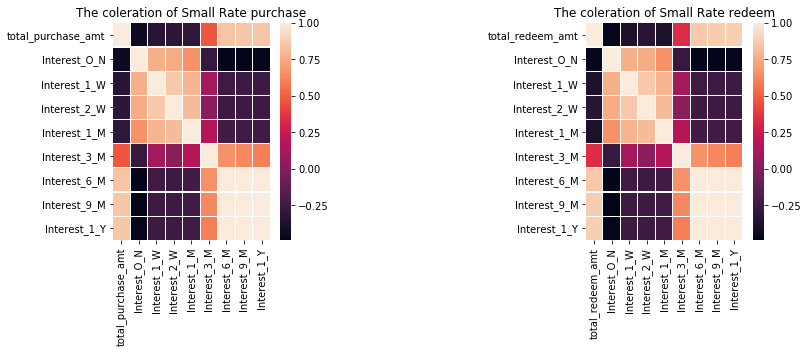

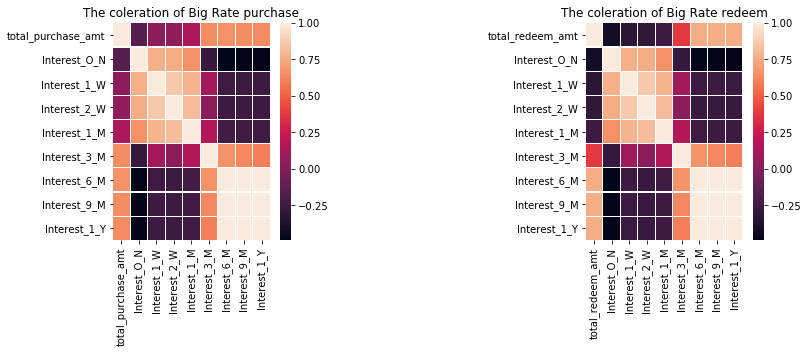

In [59]:
# 分别画出上一星期银行及支付宝利率与大额小额数据的相关性图

bank['last_date'] = bank['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("The coleration of Small Rate purchase")
temp = pd.merge(bank[['last_date']+bank_features], small_purchase, left_on='last_date', right_on='date')[['total_purchase_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  
plt.subplot(1,3,3)
plt.title("The coleration of Small Rate redeem")
temp = pd.merge(bank[['last_date']+bank_features], small_redeem, left_on='last_date', right_on='date')[['total_redeem_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  

bank['last_date'] = bank['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("The coleration of Big Rate purchase")
temp = pd.merge(bank[['last_date']+bank_features], big_purchase, left_on='last_date', right_on='date')[['total_purchase_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  
plt.subplot(1,3,3)
plt.title("The coleration of Big Rate redeem")
temp = pd.merge(bank[['last_date']+bank_features], big_redeem, left_on='last_date', right_on='date')[['total_redeem_amt']+bank_features]
sns.heatmap(temp.corr(), linewidths = 0.05)  

Text(0, 0.5, 'Rate')

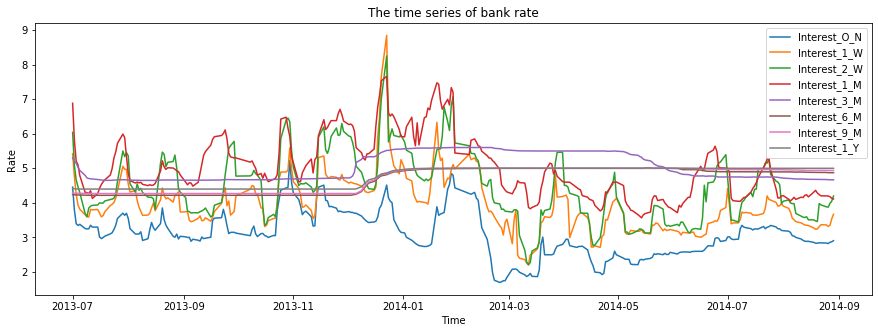

In [60]:
# 画出银行利率的时序图

plt.figure(figsize=(15,5))
for i in bank_features:
    plt.plot(bank['date'], bank[[i]] ,label=i)
plt.legend()
plt.title("The time series of bank rate")
plt.xlabel("Time")
plt.ylabel("Rate")

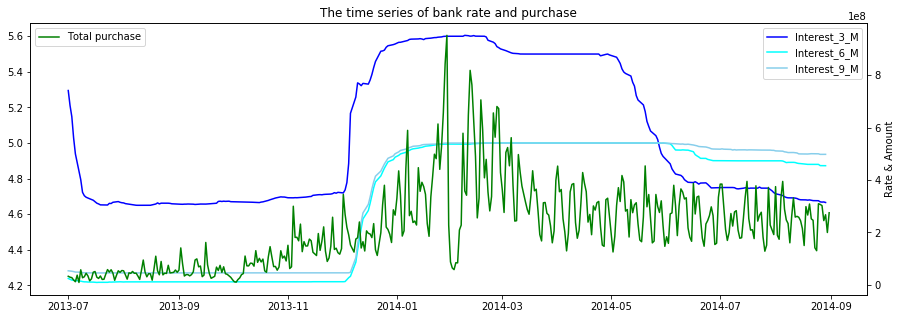

In [61]:
# 画出部分银行利率与购买量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(bank['date'], bank['Interest_3_M'],'b',label="Interest_3_M")
plt.plot(bank['date'], bank['Interest_6_M'],'cyan',label="Interest_6_M")
plt.plot(bank['date'], bank['Interest_9_M'],'skyblue',label="Interest_9_M")

plt.legend()

ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_purchase_amt'],'g',label="Total purchase")

plt.legend(loc=2)
plt.title("The time series of bank rate and purchase")
plt.xlabel("Time")
plt.ylabel("Rate & Amount")
plt.show()


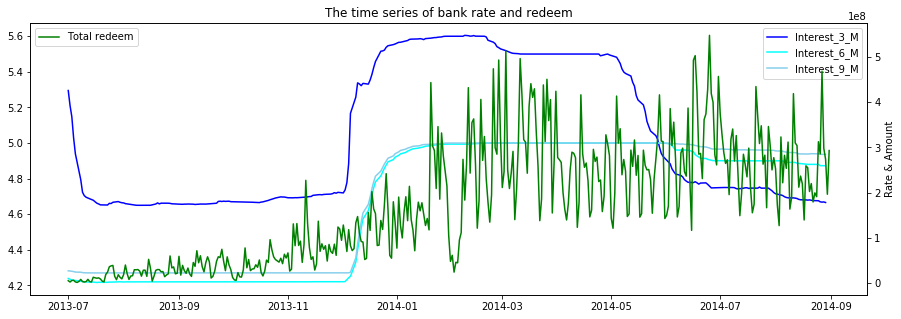

In [62]:
# 画出部分银行利率与赎回量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(bank['date'], bank['Interest_3_M'],'b',label="Interest_3_M")
plt.plot(bank['date'], bank['Interest_6_M'],'cyan',label="Interest_6_M")
plt.plot(bank['date'], bank['Interest_9_M'],'skyblue',label="Interest_9_M")

plt.legend()

ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_redeem_amt'],'g',label="Total redeem")

plt.legend(loc=2)
plt.title("The time series of bank rate and redeem")
plt.xlabel("Time")
plt.ylabel("Rate & Amount")

plt.show()


## 十、支付宝利率分析

总购买量和万份收益以及7日年化率呈比较高的相关性；赎回量和两者香瓜逆行较弱。

从时序图象来看总购买量和万份收益的变化趋势也比较一致；赎回量趋势不一致。

大额购买量和万份收益呈较高的相关性；小额的交易量以及大额的赎回量和万份收益的相关性较弱。

银行拆解利率和支付宝万份收益变化的大致趋势一致，但是支付宝波动幅度更大。

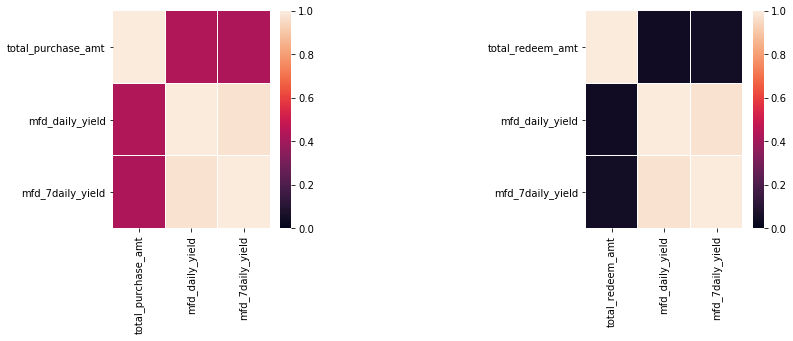

In [63]:
# 画出支付宝利率与标签的相关性图

share['last_date'] = share['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
temp = pd.merge(share[['last_date']+share_features], total_balance, left_on='last_date', right_on='date')[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0)  
plt.subplot(1,3,3)
temp = pd.merge(share[['last_date']+share_features], total_balance, left_on='last_date', right_on='date')[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0)  

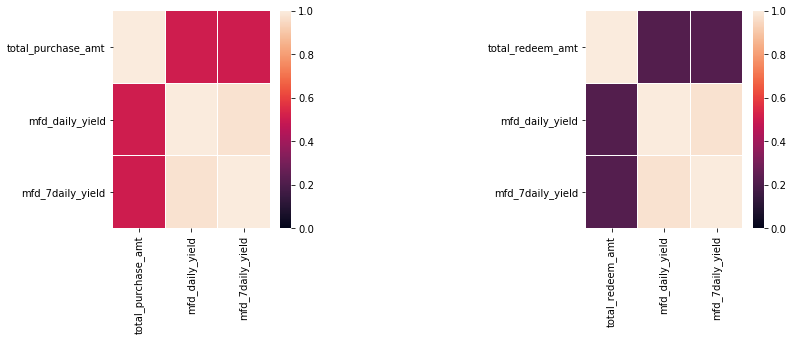

In [64]:
# 画出银行利率与标签的相关性图

share['last_week'] = share['week'] + 1
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
temp = pd.merge(share[['last_week','weekday']+share_features], total_balance, left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0)  
plt.subplot(1,3,3)
temp = pd.merge(share[['last_week','weekday']+share_features], total_balance, left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0) 

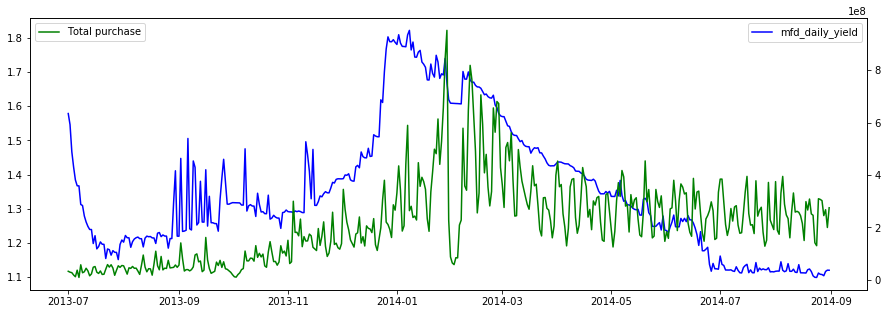

In [65]:
# 画出支付宝利率与购买量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
for i in share_features:
    plt.plot(share['date'], share[i],'b',label=i)
    break
plt.legend()
ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_purchase_amt'],'g',label="Total purchase")
plt.legend(loc=2)
plt.show()

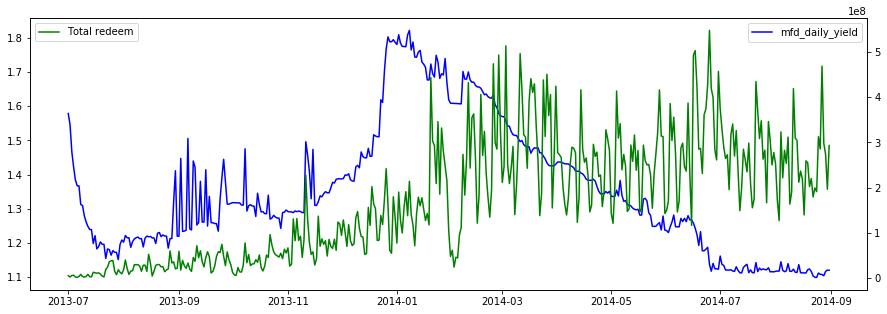

In [66]:
# 画出支付宝利率与赎回量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
for i in share_features:
    plt.plot(share['date'], share[i],'b',label=i)
    break
plt.legend()
ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_redeem_amt'],'g',label="Total redeem")
plt.legend(loc=2)
plt.show()

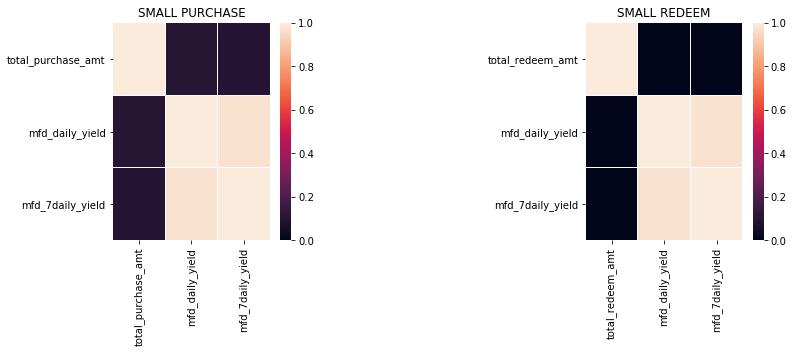

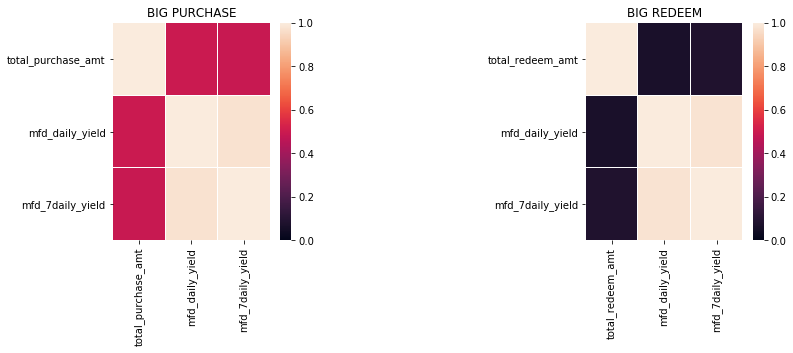

In [67]:
# 画出大额小额数据与支付宝利率的相关性图

share['last_date'] = share['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
temp = pd.merge(share[['last_date']+share_features], small_purchase, left_on='last_date', right_on='date')[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  
plt.title("SMALL PURCHASE")
plt.subplot(1,3,3)
plt.title("SMALL REDEEM")
temp = pd.merge(share[['last_date']+share_features], small_redeem, left_on='last_date', right_on='date')[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  

share['last_date'] = share['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("BIG PURCHASE")
temp = pd.merge(share[['last_date']+share_features], big_purchase, left_on='last_date', right_on='date')[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  
plt.subplot(1,3,3)
plt.title("BIG REDEEM")
temp = pd.merge(share[['last_date']+share_features], big_redeem, left_on='last_date', right_on='date')[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  

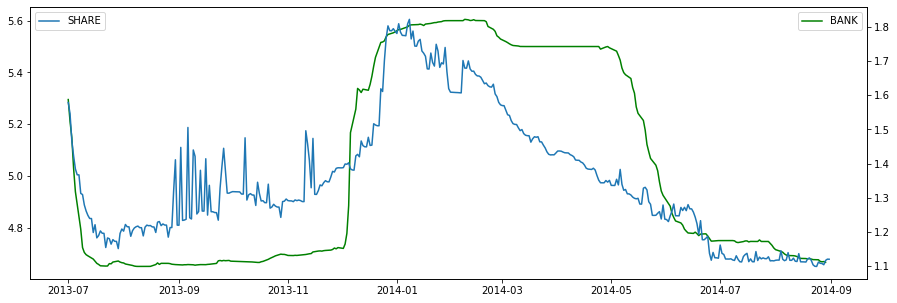

In [68]:
# 画出银行利率与支付宝利率的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(bank['date'], bank['Interest_3_M'],c='g',label= 'BANK')

plt.legend()
ax2=ax1.twinx()
plt.plot(share['date'], share['mfd_daily_yield'],label='SHARE')
plt.legend(loc=2)
plt.show()

It seems that:

1. The influence of share is more likely to act on Purchase
2. The influence of bank rate is more likely to act on Redeem
1. The influence of share rate is for short
2. The influence of bank rate is for long
